In [1]:
import numpy as np
from math import exp, log
import ipywidgets as widgets
from itertools import product
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch import nn
from torch import tensor
import numpy as np
from typing import Iterable, Tuple, List
from collections import deque
from itertools import chain
from sympy import diff, solve, symbols

_min, _max = 0.0, 1.0
%load_ext nb_black

<IPython.core.display.Javascript object>

# On Adaptive Attacks to Adversarial Example Defenses
by __Florian Tramèr, Nicholas Carlini, Wieland Brendel, Aleksander Madry__

## Warning: This paper been processed by an enthusiast. The following presentation may contain traces of `import torch` and or `f(x) = Ax`


## Overview

* What is Machine Learning, Artificial Intelligence, Deep Learning?
* A brief description functions, gradients, and learning.
* A brief look at a single linear layer.
* A network from scratch.
* An adversarial attack from scratch.

* Look at the paper's main contributions.
* Discuss why adverserial attacks of interest and is there light at the end of the tunnel.

* Questions

Adversarial attacks today: spam filter, self-driving cars, content filtering
Malware detectors - adding deleting code is different  to adding removing pixels. For images humans are the oracle for malware it's hard to evaluate. 1200 papers in the last 5 years only 36 focus on malware.

More bad news Adversarial examples appear to transfer pretty well so having direct access is not always needed.

### What is Machine Learning, Artificial Intelligence, Deep Learning?

![yesy](Learning.png)

![yesy](Overview_networks.png)

![yesy](Overview_networks.png)

# Functions, Gradients and Learning.


# Jumping in...

In [2]:
def plot_functions(our_guesses=None, errors=None):
    figure = plt.figure(figsize=(10, 8))
    if our_guesses:
        plt.plot(distances, our_guesses, label="Our guesses")
    if errors:
        plt.plot(distances, errors, label="Errors")
    plt.plot(distances, temperatures, label="Distance Vs. Temperature")
    plt.plot(
        distances, derivative_temperatures, label="Derivative of Temp wrt. Distance"
    )
    plt.vlines(
        x=zero_grad_at_x, ymin=y_min, ymax=y_max, linestyles="dotted", colors="black"
    )
    plt.hlines(y=0, xmin=x_min, xmax=x_max, linestyles="dotted", colors="black")
    plt.title("Quadratic function and its gradient")
    plt.xlabel("Distance [m]", size=20)
    plt.ylabel("Temperature [C]", size=20)
    plt.legend()


def plot_patch_example(x, A, y_hat, y, losses=None):
    if losses:
        fig, ((ax1, ax2, ax3, ax4), (ax_n, ax5, ax_n1, ax_n2)) = plt.subplots(
            2, 4, figsize=(25, 8)
        )
        ax_n.axis("off"), ax_n1.axis("off"), ax_n2.axis("off")
        #         fig,  (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25,8))
        ax5.plot(losses, label="loss vs iteration")
        ax5.set_title("loss vs. iteration", size=30)
    else:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 8))
    ax1.imshow(x.numpy(), cmap="viridis", vmin=_min, vmax=_max)
    ax1.set_title("x", size=100)
    ax2.imshow(A.detach().numpy(), cmap="viridis", vmin=_min, vmax=_max)
    ax2.set_title("A", size=100)
    ax3.imshow(y_hat.detach().numpy(), cmap="viridis", vmin=_min, vmax=_max)
    ax3.set_title("y_hat", size=100)
    ax4.imshow(y.numpy(), cmap="viridis", vmin=_min, vmax=_max)
    ax4.set_title("y", size=100)
    return fig

<IPython.core.display.Javascript object>

## $\ f(x) = x+2$     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    $\ f'(x) = 1$

## $\ f_{temperature}(x) = a - b\times x + c\times x^2 $  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\ f'_{temperature}(x) = - b + 2 \times c\times x $

In [9]:
a = 3.5
b = 6.3
c = 1.07

x = symbols("x")

f_temperature = a - b * x + c * x ** 2
f_dot_temperature = diff(f_temperature)

print(f_dot_temperature)
zero_grad_at_x = float(solve(f_dot_temperature)[0])
print(f"{zero_grad_at_x=:.2f}")

2.14*x - 6.3
zero_grad_at_x=2.94


<IPython.core.display.Javascript object>

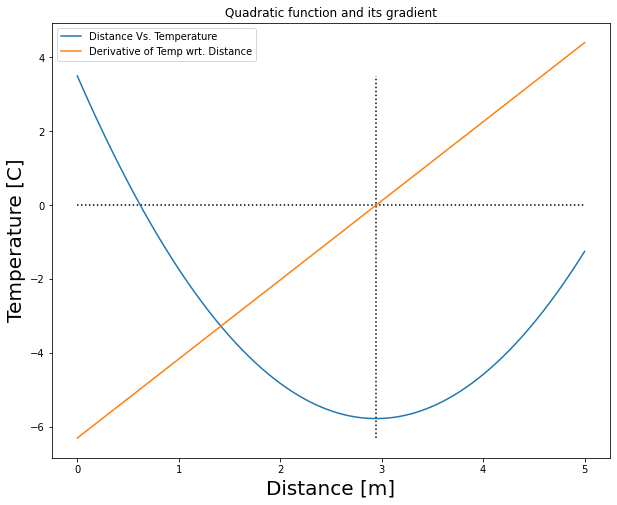

<IPython.core.display.Javascript object>

In [10]:
x_min, x_max = -0, 5

distances = np.linspace(x_min, x_max, 1000).tolist()  # 100 data

f_temperature = lambda x: a - b * x + c * (x ** 2)
f_dot_temperature = lambda x: -b + 2 * x * c


y_min = f_dot_temperature(x_min)
y_max = max(f_temperature(x_max), f_temperature(x_min))

temperatures = [f_temperature(distance) for distance in distances]
derivative_temperatures = [f_dot_temperature(distance) for distance in distances]


plot_functions()

In [11]:
print(f"True Parameters: d={a}, e={b}, f={c}")


@widgets.interact(d=(-2.0, 8.0, 0.1), e=(-2.0, 8.0, 0.1), f=(-2.0, 8.0, 0.05))
def manual_fitting(d, e, f):
    # d, e, f = 2., -5., 1.1
    our_model = lambda x: d - e * x + f * x ** 2
    our_guesses = [our_model(x) for x in distances]
    errors = [y_hat - y for y_hat, y in zip(our_guesses, temperatures)]
    plot_functions(our_guesses, errors)

True Parameters: d=3.5, e=6.3, f=1.07


interactive(children=(FloatSlider(value=3.0, description='d', max=8.0, min=-2.0), FloatSlider(value=3.0, descr…

<IPython.core.display.Javascript object>

* What is a good strategy for finding the optimal parameters?
* What would be a good strategy for determining the computation graph?


* __Function:__ A set of parameters. A computation graph. Takes in a numbers and produces a numbers.
* __Gradient:__ The rate of change of a value with respect to another value.
* __Learning:__ Systematic method for finding a set of function parameters and or computation graph such that a function maps inputs to desired outputs.


# A brief look at a linear layer
__The work horse of neural networks.__


# \$ F(x) = Ax\$ 
\$ F(x)\$ is a linear transform of \$x\$. It maps every x to a new variable y. A is a matrix which holds our parameters. 

### Looking at higher dimension data and using pytorch to compute gradients for us,
### We're going to take a 3 x 3 image and pass it through a linear transform to produce \$y\$ a new image.
### We'll then try and find the parameters of \$A\$ such that \$y\$ is equal to a checker board.

tensor([[0.3747, 0.5947, 0.4782],
        [0.0948, 0.3975, 0.0939],
        [0.5885, 0.8493, 0.7499]])
Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True)
tensor([[0.3747, 0.5947, 0.4782],
        [0.0948, 0.3975, 0.0939],
        [0.5885, 0.8493, 0.7499]], grad_fn=<MmBackward>)


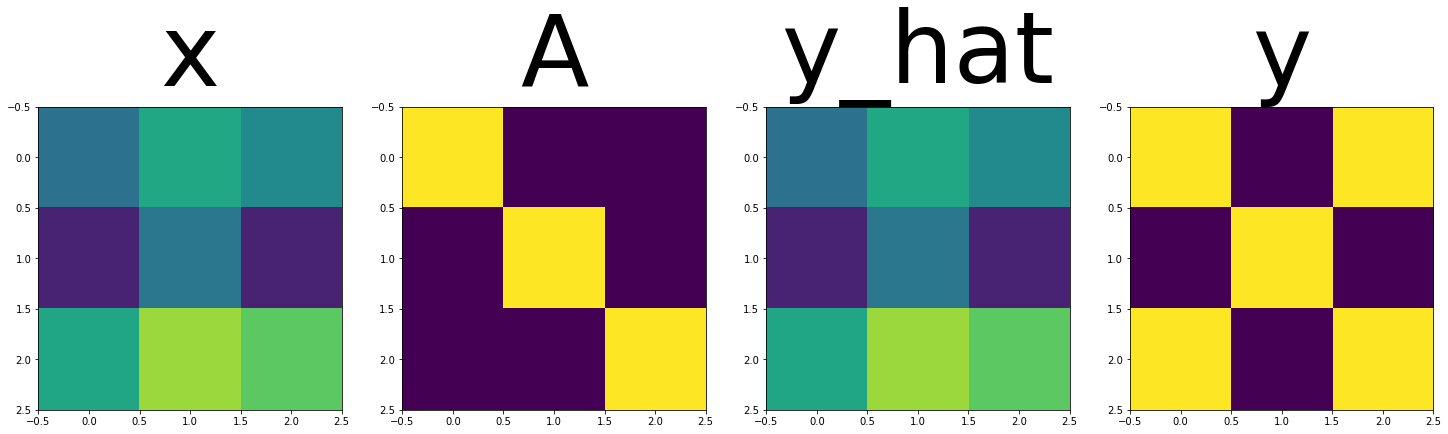

<IPython.core.display.Javascript object>

In [12]:
# x is our input.
x = torch.rand(3, 3)

# y is our target, truth.
y = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 1.0]])

# A is a set of our parameters that we can control
A = nn.Parameter(
    torch.tensor(
        [
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
        ]
    ),
    requires_grad=True,
)

# f is a our computation graph that uses parameters A and maps x to y_hat
f = lambda x: A @ x

# Apply mapping f to x to get our prediction y_hat
y_hat = f(x)

plot_patch_example(x=x, A=A, y_hat=y_hat, y=y)
print(x)
print(A)
print(y_hat)

In [13]:
# We have to decide on a criterion to determine how good out model is doing.
criterion = lambda y_hat, y: (y - y_hat)
print(f"loss = {criterion(torch.tensor([1., 1.]), torch.tensor([2.,1,]))}")

loss = tensor([1., 0.])


<IPython.core.display.Javascript object>

In [14]:
prev_loss = 0
A = nn.Parameter(
    torch.tensor(
        [
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
        ]
    ),
    requires_grad=True,
)


@widgets.interact(parameter=(0.0, 6.0, 1.0))
def grad_explore(parameter):
    global prev_loss
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

    new_A_values = A.clone()
    new_A_values[0][0] = parameter
    with torch.no_grad():
        A.copy_(new_A_values)

    y_hat = f(x)
    loss_raw = criterion(y_hat, y)
    #     print(loss_raw)
    ax2.imshow(loss_raw.detach().numpy(), cmap="viridis", vmin=_min, vmax=_max)
    [
        ax2.text(i - 0.2, j, f"{loss_raw.detach().numpy()[i][j]:.2f}", c="w", size=30)
        for i, j in product(range(3), range(3))
    ]

    ax2.set_title("Loss (before sum)", size=30)
    loss = loss_raw.sum()
    print(f"{prev_loss=}, {loss.item()=}, diff = {prev_loss - loss.item()}")
    prev_loss = loss.item()
    loss.backward()
    ax1.imshow(A.detach().numpy(), cmap="viridis", vmin=_min, vmax=_max)
    [
        ax1.text(i - 0.2, j, f"{A[i][j]:.2f}", c="w", size=30)
        for i, j in product(range(3), range(3))
    ]
    ax1.set_title("A - Parameters", size=30)
    #     print(A.grad)
    ax3.imshow(A.grad.detach().numpy(), cmap="viridis", vmin=_min, vmax=_max)
    [
        ax3.text(i - 0.2, j, f"{A.grad.detach().numpy()[i][j]:.2f}", c="w", size=30)
        for i, j in product(range(3), range(3))
    ]
    ax3.set_title("Gradients", size=30)
    #     print(A.grad)
    A.grad.zero_()
    print()

interactive(children=(FloatSlider(value=3.0, description='parameter', max=6.0, step=1.0), Output()), _dom_clas…

<IPython.core.display.Javascript object>

### Now we have:
1. A function \$F(x)\$ which is our simple matrix multipy and set of parameters \$ A \$. 
2. Acess to the gradients of our loss wrt. the parameters.
3. A basic intution on how we can tweak the paramters to move the loss in the direction we want.
4. What else determines the output of our function? Yip: \$x\$

### The training loop
__A training loop is a procdure that modifies the paramaters of a function to minimize an objective or loss function.__

In [15]:
# On thing that was ommited as it's easier to see the gradients
criterion = lambda y_hat, y: (y - y_hat) ** 2

<IPython.core.display.Javascript object>

In [16]:
# Pass data through the function to get a prediction.
y_hat = f(x)
# Evaluate how good that prediction is using the criterion.
loss = criterion(y_hat, y).sum()
# Compute the gradients
loss.backward()

# Now we have the direction in which to tweak the parameters of A in order to lower the loss.
# I won't go into regularization and weight decay but let's just look at this as one way to update the parameters.
new_A_values = A - A.grad*0.01 # - 2*A*0.01
print(f"{A.grad=}")
with torch.no_grad():
    A.copy_(new_A_values)
A.grad.zero_()
print(f"{A=}")
print(f"{loss=}")


A.grad=tensor([[ 5.5215,  2.7908,  8.1648],
        [-0.5558, -0.4434, -0.7709],
        [ 0.4626,  0.5502,  0.5831]])
A=Parameter containing:
tensor([[ 4.9448e+00, -2.7908e-02, -8.1648e-02],
        [ 5.5578e-03,  1.0044e+00,  7.7092e-03],
        [-4.6261e-03, -5.5017e-03,  9.9417e-01]], requires_grad=True)
loss=tensor(12.8732, grad_fn=<SumBackward0>)


<IPython.core.display.Javascript object>

In [11]:
# Once we have a loss function and a way to track graidents with respect to the loss
# all that is left is to iterate in a somewhat smart manner.

<IPython.core.display.Javascript object>

tensor([[0.3747, 0.5947, 0.4782],
        [0.0948, 0.3975, 0.0939],
        [0.5885, 0.8493, 0.7499]])
Parameter containing:
tensor([[ 0.6070, -4.4968,  1.6966],
        [ 0.4674,  3.4651, -0.7757],
        [ 0.3314, -4.4444,  1.8650]], requires_grad=True)
tensor([[ 0.7998,  0.0144,  1.1402],
        [ 0.0470,  0.9965, -0.0328],
        [ 0.8006,  0.0144,  1.1397]], grad_fn=<MmBackward>)
tensor([[1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]])
tensor([[ 0.2002, -0.0144, -0.1402],
        [-0.0470,  0.0035,  0.0328],
        [ 0.1994, -0.0144, -0.1397]], grad_fn=<SubBackward0>)
CPU times: user 1.35 s, sys: 19.5 ms, total: 1.37 s
Wall time: 1.39 s


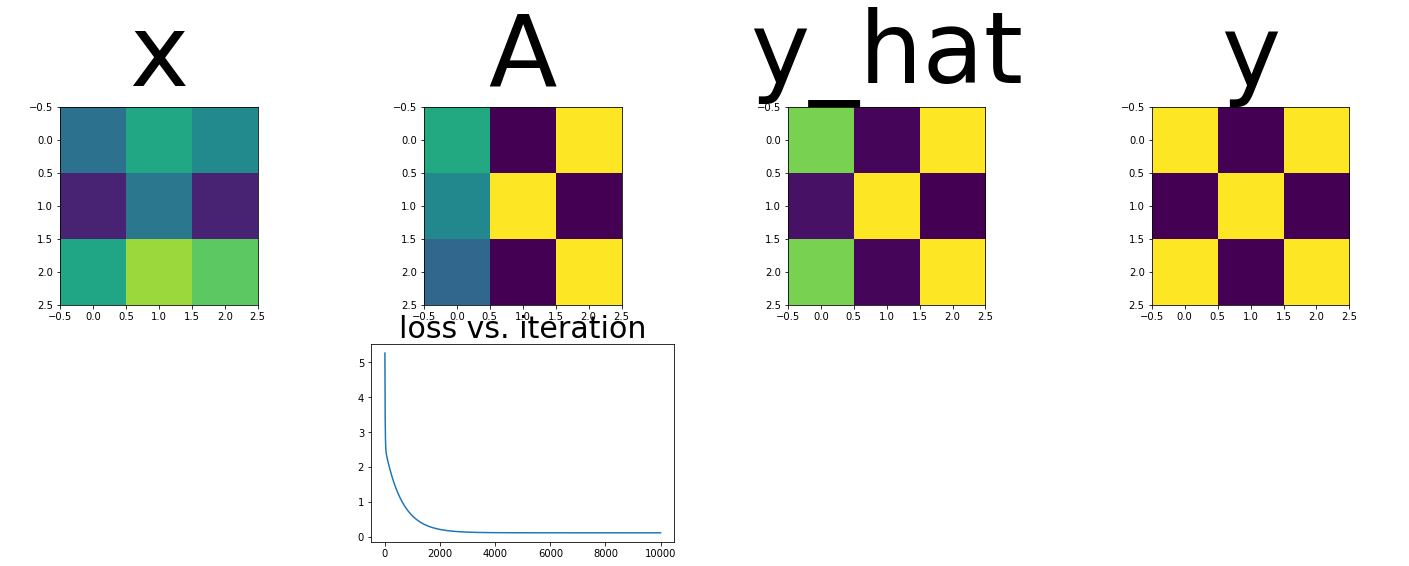

<IPython.core.display.Javascript object>

In [17]:
%%time
losses=[]
parameter_a_0 =[]
grad_a_0 =[]
A = nn.Parameter(torch.rand(3,3), requires_grad=True)

for _ in range(10_000):
    y_hat = f(x)
    loss = criterion(y_hat, y).sum()
    loss.backward()
    # Now we have the direction in which to tweak the parameters of A in order to lower the loss.
    # I won't go into regularization and weight decay but let's just look at this as one way to update the parameters.
    new_A_values = A - A.grad*0.01         #- 2*A*0.0000001
    with torch.no_grad():
        A.copy_(new_A_values)
    A.grad.zero_()
    losses.append(loss.item())

# Make a prediction 
y_hat = f(x)

plot_patch_example(x=x, A=A, y_hat=y_hat, y=y, losses=losses)
print(x)
print(A)
print(y_hat)
print(y)
print(y-y_hat)


# A "Real" Neural Network
1. Train a simple convolutional neural network to classify hand written digits
2. Attack the network to discover adversrial examples
3. Discuss what an attack is? When is it a valid attack?  

In [20]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

<IPython.core.display.Javascript object>

In [21]:
test_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

<IPython.core.display.Javascript object>

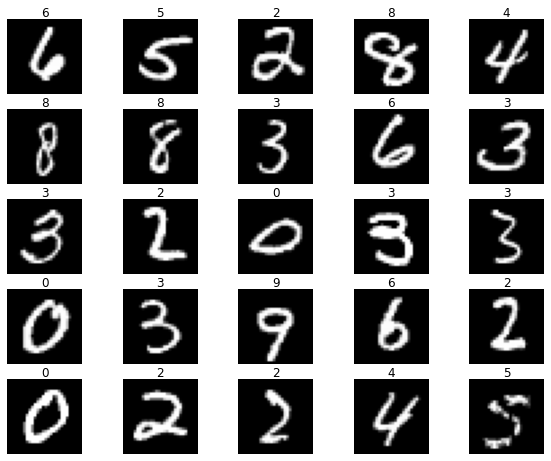

<IPython.core.display.Javascript object>

In [22]:
# def show_tensor()
def show_items(dataset, num_items):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, num_items//5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_data[sample_idx]
        ax = figure.add_subplot(rows, cols, i)
        ax.set_title(label, y=1.0, pad=2)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    return plt.show()
show_items(dataset=train_data, num_items=25)


In [24]:
# Baseline MNIST
from torch import nn


class BaseLine(nn.Module):
    def __init__(self, n_out):
        super(BaseLine, self).__init__()
        self.conv1 = nn.Sequential(  # input_size=(1*28*28)
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),  # input_size=(6*28*28)
            nn.MaxPool2d(kernel_size=2, stride=2),  # output_size=(6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),  # input_size=(16*10*10)
            nn.MaxPool2d(2, 2),  # output_size=(16*5*5)
        )
        self.fc1 = nn.Sequential(nn.Linear(16 * 5 * 5, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84, n_out)

    #         self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


network = BaseLine(n_out=10)

<IPython.core.display.Javascript object>

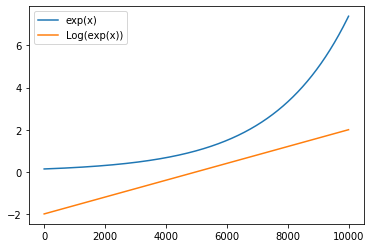

<IPython.core.display.Javascript object>

In [25]:
plt.plot([exp(o) for o in np.linspace(-2.0, 2.0, 10000)], label="exp(x)")
plt.plot([log(exp(o)) for o in np.linspace(-2.0, 2.0, 10000)], label="Log(exp(x))")
plt.legend()

pytorch implementation: 0.7642521858215332


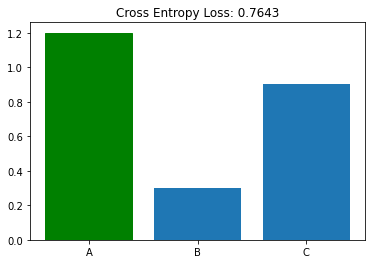

<IPython.core.display.Javascript object>

In [26]:
# Cross entropy loss
# Output from the Neural Network
#        A    B    C
y_hat = [1.2, 0.3, 0.9]
y = 0  # true class is B
cross_entropy_loss = lambda x, y: -x[y] + log(sum([exp(x_i) for x_i in x]))
bars = plt.bar(x=["A", "B", "C"], height=y_hat)
bars[y].set_color("g")
plt.title(f"Cross Entropy Loss: {cross_entropy_loss(y_hat,y):.4f}")


loss_function = nn.CrossEntropyLoss()

pred = torch.FloatTensor(y_hat).unsqueeze(0)
target = torch.LongTensor([y])
print(f"pytorch implementation: {loss_function(pred, target)}")

In [27]:
from tqdm.notebook import tqdm
from random import randint

#  what is the training process.
losses = []
lr = 0.001
network = BaseLine(n_out=10)
opt = torch.optim.SGD(network.parameters(), lr=lr)


def train(net, train_data, loss_function):
    for i, (images, labels) in tqdm(
        enumerate(DataLoader(train_data, batch_size=2)), total=len(train_data)
    ):
        preds = net(images)
        loss = loss_function(preds, labels)
        losses.append(loss.item())

        # Back propergate
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i > 20_000:
            break


train(net=network, train_data=train_data, loss_function=loss_function)

  0%|          | 0/60000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

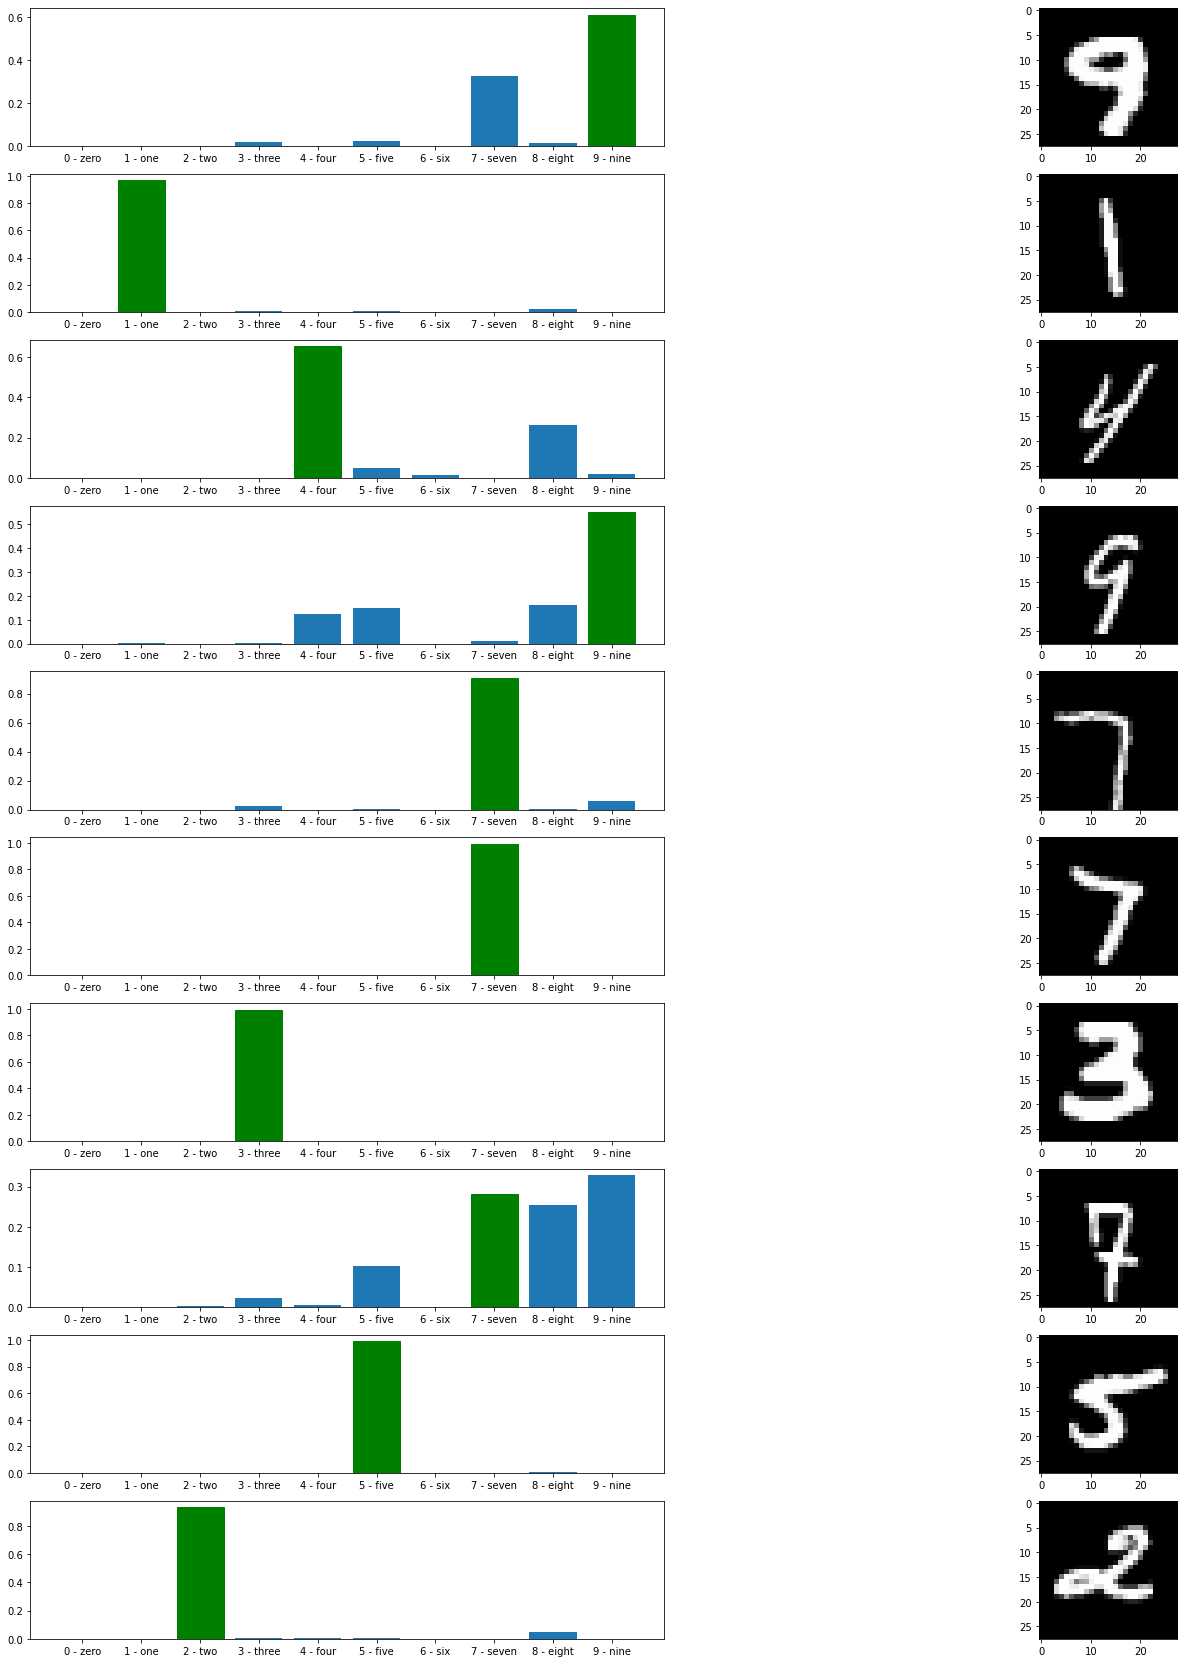

<IPython.core.display.Javascript object>

In [28]:
#
num_plots = 10
network.eval()

fig, axes = plt.subplots(num_plots, 2, figsize=(25, num_plots * 3))
for i in range(num_plots):
    ax1, ax2 = axes[i]
    sample_idx = randint(0, 10000)
    image, label = train_data[sample_idx]

    preds = network(image.unsqueeze(0))
    preds = torch.softmax(preds, 1).detach().squeeze(0).numpy()

    bars = ax1.bar(x=test_data.classes, height=preds)
    bars[label].set_color("g")

    ax2.imshow(image.squeeze(), cmap="gray")

In [29]:
# Now that we have an intuition for how a network works and is trained. Let's attack it!
def attack(
    net, train_data, loss_function, num_iterations=10_000, epsilon=0.1, alpha=2 / 255
):
    net.eval()
    attack_images, labels = next(iter(DataLoader(train_data, batch_size=20)))
    original_images = attack_images.data
    for i in tqdm(range(num_iterations)):
        # Magic autodiff working for us under the hood.
        attack_images.requires_grad = True
        outputs = net(attack_images)

        cost = loss_function(outputs, labels)
        cost.backward()

        adverserial_purturbed_images = attack_images + alpha * attack_images.grad.sign()
        attack_noise = torch.clamp(
            adverserial_purturbed_images - original_images, min=-epsilon, max=epsilon
        )

        attack_images = torch.clamp(
            original_images + attack_noise, min=0, max=1
        ).detach_()
    return attack_images, original_images, labels, attack_noise.detach()


attack_images, images, labels, attack_noise = attack(network, train_data, loss_function)

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

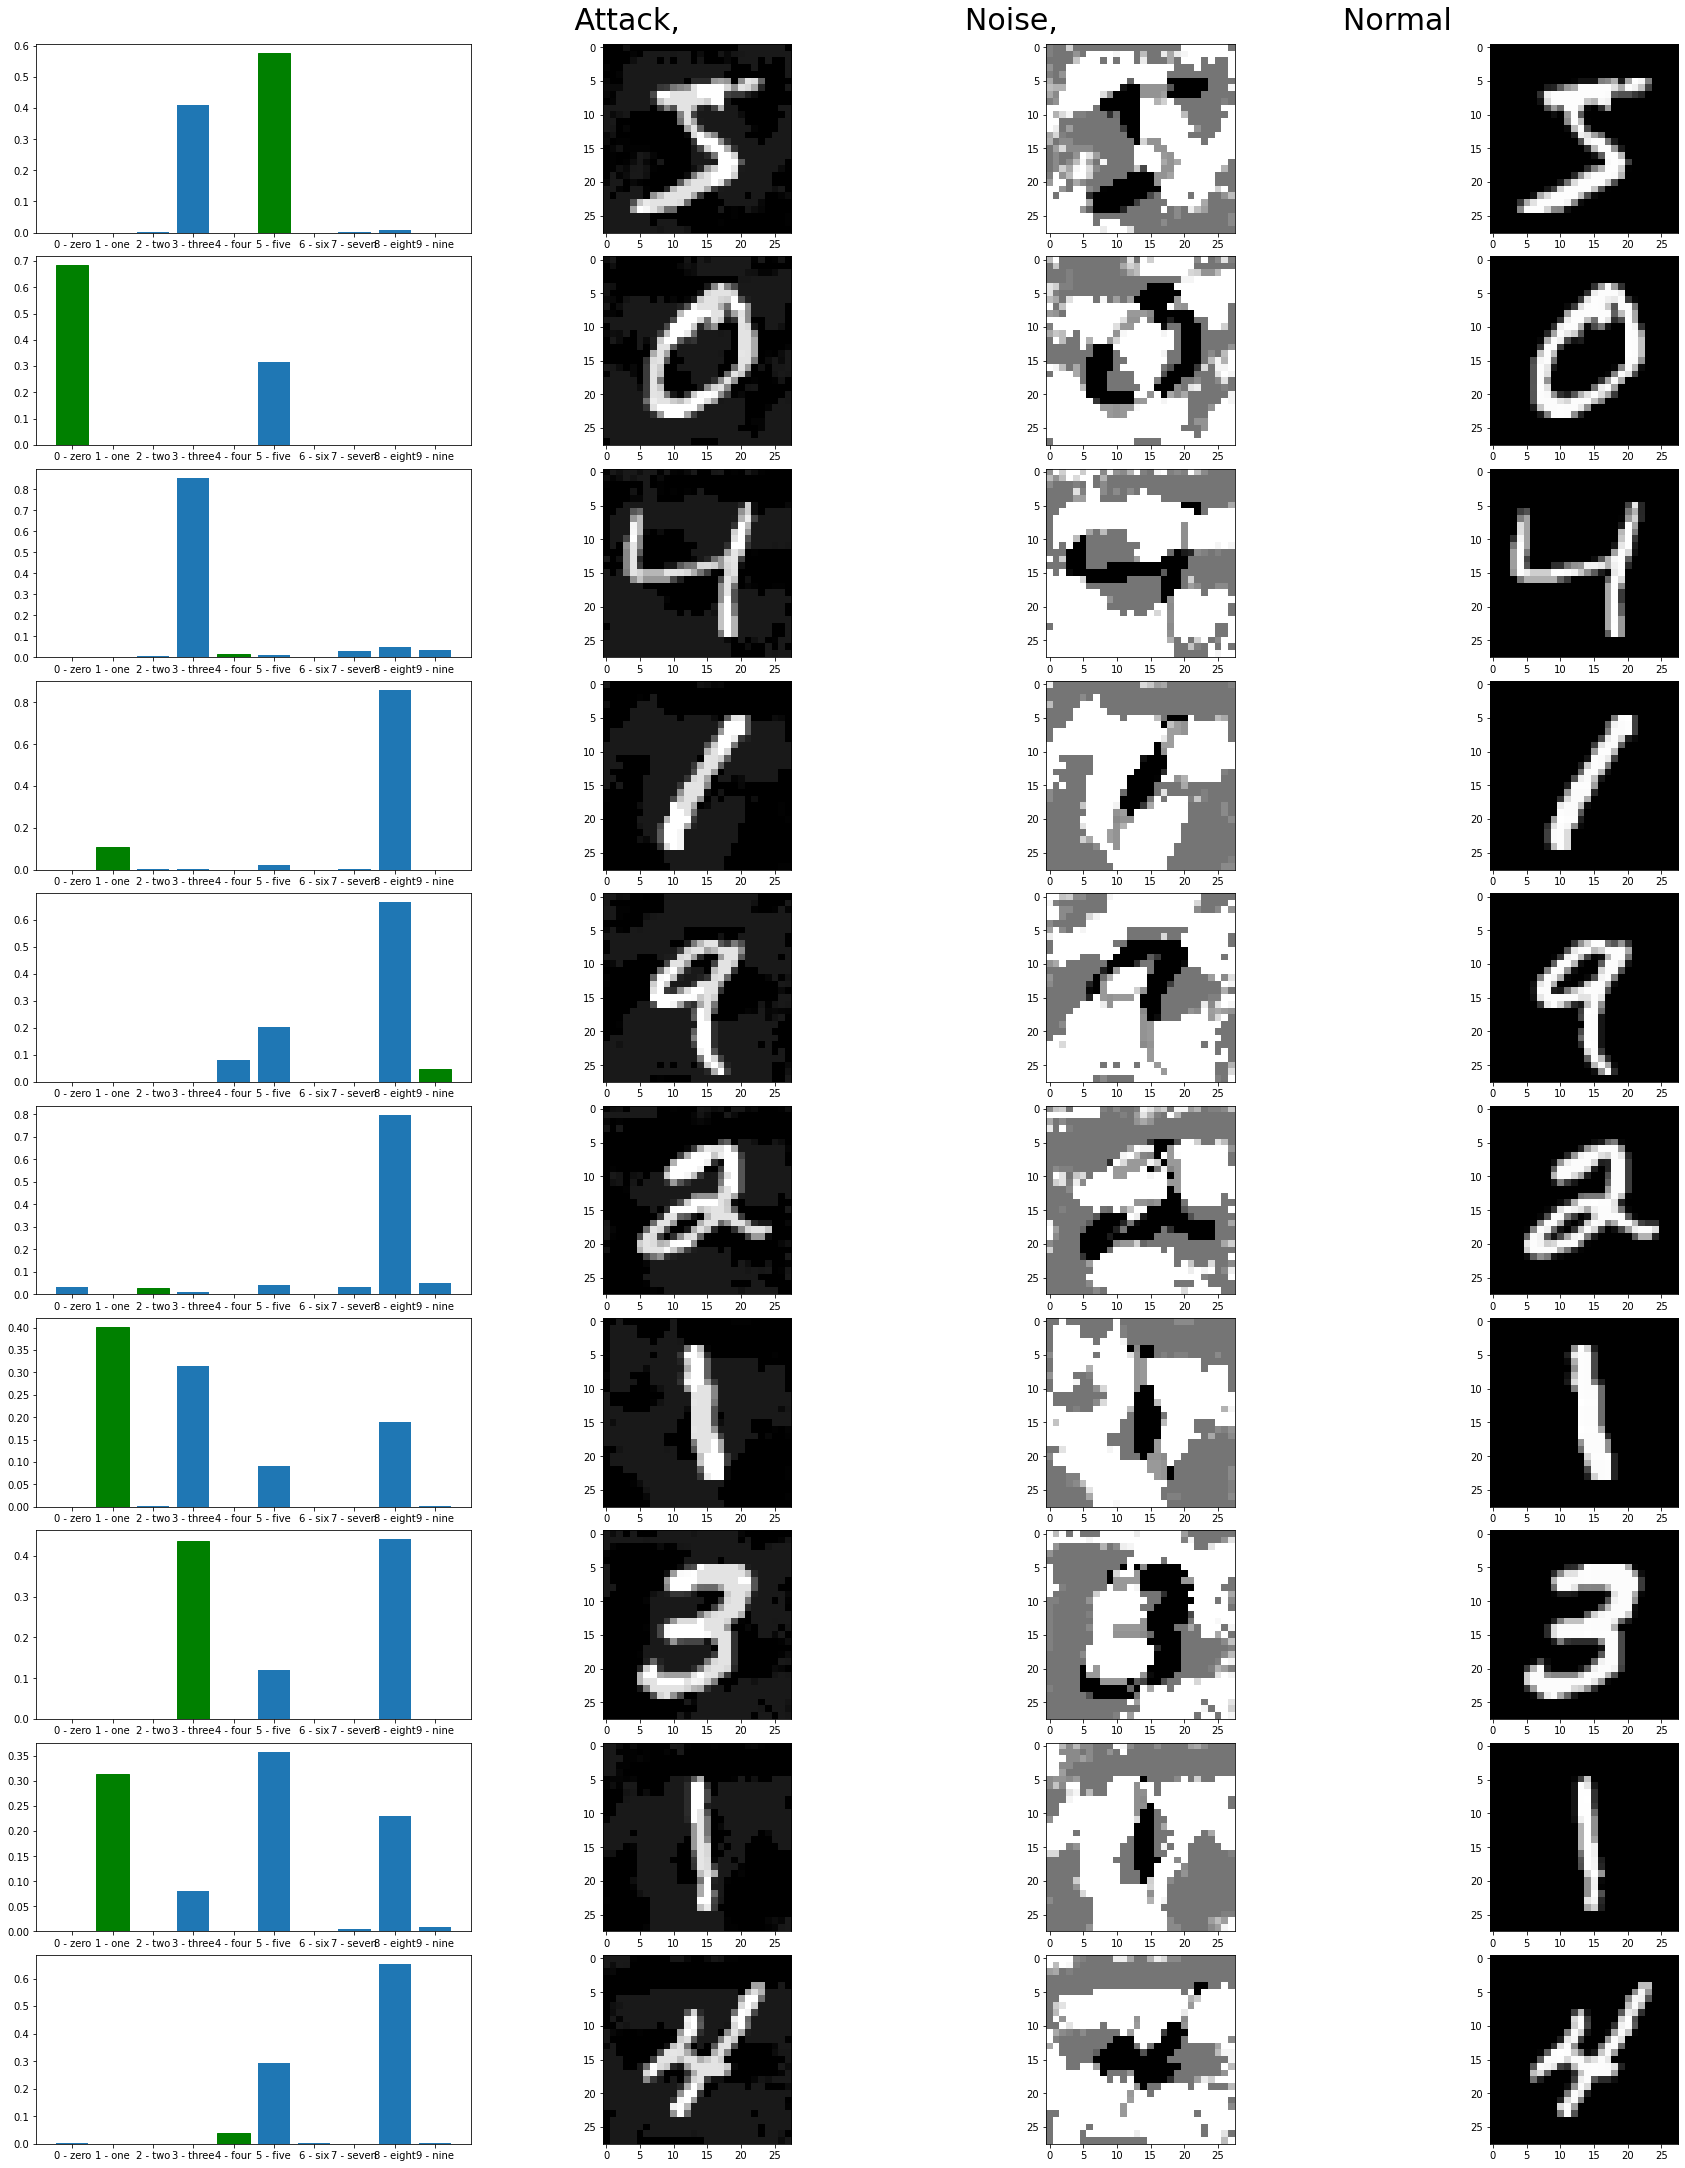

<IPython.core.display.Javascript object>

In [30]:
num_plots = 10
network.eval()

fig, axes = plt.subplots(
    num_plots, 4, figsize=(25, num_plots * 3), constrained_layout=True
)
fig.suptitle(
    "                       Attack,                              Noise,                              Normal",
    fontsize=30,
)
for i in range(num_plots):
    ax1, ax2, ax3, ax4 = axes[i]
    image, label = attack_images[i], labels[i]
    preds = network(image.unsqueeze(0))
    preds = torch.softmax(preds, 1).detach().squeeze(0).numpy()

    bars = ax1.bar(x=test_data.classes, height=preds)
    bars[label].set_color("g")

    ax3.imshow(attack_noise[i].squeeze(), cmap="gray")
    ax2.imshow(attack_images[i].squeeze(), cmap="gray")
    ax4.imshow(images[i].squeeze(), cmap="gray")

# Some of the attacks the paper revealed
1. __Winner takes all__ - Break the gradients so we cannot easily "follow" them to an adversarial example.
2. __The odds are odd__ - Here they look at the logits! Compare clean and clean + noise. Here a targeted attack breaks the game!
3. __Are generative classifiers more robust__ - VAE, 4 loss functions and check KL divergence. Again, a targeted attack breaks the game!
4. __Robust Sparse Fouier Transform__ - Represent the image as sum of Fourier coefficents. Wrap it all in a differentiable function and follow the gradient.
  

# Look at the paper's main contributions.
1. The Recurring Attack Themes - Simple; Wrap the defence and march (or jump); Decompose; Adapt the attack (targeted vs. not); Objective must be a good proxy; Use different optimzations methods;  
2. "For any proposed attack, it is possible to build a non-robust defense that prevents that attack." - These are of little value.
3. _Wise words for academia._ But we can take away the sentiment which is the asymetry of attacking and defending.
4. Paper style as a narative was refreshing and showed the path taken more than just the end result.



# Why are adverserial attacks of interest and is there light at the end of the tunnel.
* Deep learning models like the one we built are being deployed far and wide. 
* It's unclear we'll get to a point where we can have high accuracy and robust models.
* This was white box attacking (full access) is that really a threat model we care about? - (pretrained models)

# Questions